In [58]:
import cv2
import os
import unittest
import numpy as np
import matplotlib.pyplot as plt
# import gco
from gco import pygco as gco
# from scipy import linalg
# from tqdm import tqdm
import os


def distance(c1, c2):
    res = abs(int(c1[0]) - int(c2[0])) + abs(int(c1[1]) - int(c2[1])) + abs(int(c1[2]) - int(c2[2]))
    return res / 10


def lse(c1, c2):
    sq = np.square(c1 - c2)
    dist = np.sum(sq, axis=-1, keepdims=True)
    return np.sqrt(dist) / 5


def get_part1(k1, r1, k2, r2):
    m = np.dot(k2, r2.T)
    n = np.dot(r1, np.linalg.inv(k1))
    return np.dot(m, n)


def get_part2(k2, r2, t1, t2):
    m = np.dot(k2, r2.T)
    n = (t1 - t2)
    n = n.T
    return np.dot(m, n)


def get_video(path):
    file_name_list = os.listdir(path)
    return file_name_list


def get_KRT(filepath):
    K = []
    R = []
    T = []
    f = open(filepath)
    frame_n = int(f.readline())
    f.readline()
    for i in range(frame_n):
        k_cur = []
        line1 = f.readline().split()
        line2 = f.readline().split()
        line3 = f.readline().split()
        k_cur.append(np.array([float(x) for x in line1], dtype=np.float32))
        k_cur.append(np.array([float(x) for x in line2], dtype=np.float32))
        k_cur.append(np.array([float(x) for x in line3], dtype=np.float32))

        r_cur = []
        line1 = f.readline().split()
        line2 = f.readline().split()
        line3 = f.readline().split()
        r_cur.append(np.array([float(x) for x in line1], dtype=np.float32))
        r_cur.append(np.array([float(x) for x in line2], dtype=np.float32))
        r_cur.append(np.array([float(x) for x in line3], dtype=np.float32))

        line1 = f.readline().split()
        t_cur = np.array([[float(x) for x in line1]], dtype=np.float32)
        f.readline()
        f.readline()
        k_cur = np.matrix(k_cur, dtype=np.float32)
        r_cur = np.matrix(r_cur, dtype=np.float32)
        t_cur = np.matrix(t_cur, dtype=np.float32)
        K.append(k_cur)
        R.append(r_cur)
        T.append(t_cur)
    # K = np.asarray(K)
    # R = np.asarray(R)
    # T = np.asarray(T)
    return K, R, T


def get_cood_matrix(h, w):
    res = np.zeros([3, h, w], dtype=np.float32)
    for i in range(h):
        for j in range(w):
            res[0][i][j] = j
            res[1][i][j] = i
            res[2][i][j] = 1
    return res


def conujugate_coordinates(K, R1, T1, R2, T2, coorsxy, d, h, w):
    coorsxy = np.reshape(coorsxy, [3, -1])
    d = np.reshape(d, [1, -1])

    depth = (T1 - T2).T * d
    remap = (K * R2.T) * ((R1 * K.I) * coorsxy + depth)
    remap = np.divide(remap, remap[2, :])
    remap = np.reshape(np.asarray(remap), [3, h, w])
    return remap


def get_depth_map(unary, smooth, lambda_factor=0.06):
    labels = gco.cut_grid_graph_simple(unary, smooth * lambda_factor, connect=4, n_iter=-1)
    # labels = gco.cut_grid_graph_simple(unary, smooth * lambda_factor, connect=4, n_iter=-1)
    # Set up the data cost (unary potentials)
    labels = labels.reshape(H, W)
    # data_cost = unary
    # 
    # # Set up the smoothness cost and the label cost (for label compatibility)
    # # Usually, the smoothness cost is a 2D array (num_labels, num_labels) where the
    # # entry [i, j] represents the cost between label i and label j.
    # smooth_cost = smooth * lambda_factor
    # 
    # # Define the label for each pixel
    # num_labels = unary.shape[0]
    # num_nodes = unary.shape[1]
    # 
    # # Create a grid graph
    # gc = gco.create_general_graph(num_nodes, num_labels, True)
    # 
    # # Set the unary potentials
    # gc.set_data_cost(data_cost)
    # 
    # # Set the smoothness (pairwise) cost
    # gc.set_smooth_cost(smooth_cost)
    # height, width = img1.shape[:2]
    # # Specify the 4-connectivity for each node in the graph
    # for node in range(num_nodes):
    #     if node % width != width - 1:  # if not on the right edge
    #         gc.set_neighbor_pair(node, node + 1, 1)
    #     if node < num_nodes - width:  # if not on the bottom edge
    #         gc.set_neighbor_pair(node, node + width, 1)
    # 
    # # Optionally, you can set more complicated spatially varying pairwise costs
    # # using gc.set_neighbor_pair_cost(node1, node2, cost)
    # 
    # # Perform the optimization using alpha-expansion
    # gc.expansion(-1)  # n_iter is the number of iterations
    # 
    # # Get the resulting labeling
    # result_labels = gc.get_labels()
    return labels


def load_depthmaps(directory, sequence):
    D = []
    for i in range(len(sequence)):
        depthmap_name = os.path.join(directory, "depth_" + str(i).zfill(4) + ".npy")

        depthmap = np.load(depthmap_name)
        D.append(depthmap)
    return D

In [59]:
files = 'data/Road/src/'
txt_path = 'data/Road/cameras.txt'
K, R, T = get_KRT(txt_path)

video = get_video(files)
print(video)
img = cv2.imread(files + video[1])
H, W, D = img.shape
disparity = np.arange(0, 0.03, 0.03 / 65)
d_number = len(disparity)

choose_frame = 100

sequence = np.arange(choose_frame + 1, choose_frame + 9)
# sequence = np.append(choose_frame - 3, sequence)
num_frame = sequence.shape[0]
print(num_frame)
L = np.zeros((H, W, d_number))

print(f'Disparity Initialization choose_fram =={choose_frame} sequence ={sequence}')
use_bundle = False
depth_map_save = []
img1 = cv2.imread(files + video[choose_frame])

h, w = H, W
levels = d_number
depth_values = disparity
I_t = img1
sigma_c = 1
sigma_d = 2.5
x_h = get_cood_matrix(h, w)  # [3, h, w]
d = np.zeros([h, w], dtype=np.float32)  # [h, w]
L = np.zeros([levels, h, w], dtype=np.float32)  # [levels, h, w]
# cv2.imshow('img', I_t)

['test0084.jpg', 'test0090.jpg', 'test0047.jpg', 'test0053.jpg', 'test0133.jpg', 'test0127.jpg', 'test0126.jpg', 'test0132.jpg', 'test0052.jpg', 'test0046.jpg', 'test0091.jpg', 'test0085.jpg', 'test0093.jpg', 'test0087.jpg', 'test0050.jpg', 'test0044.jpg', 'test0078.jpg', 'test0124.jpg', 'test0130.jpg', 'test0118.jpg', 'test0119.jpg', 'test0131.jpg', 'test0125.jpg', 'test0079.jpg', 'test0045.jpg', 'test0051.jpg', 'test0086.jpg', 'test0092.jpg', 'test0096.jpg', 'test0082.jpg', 'test0069.jpg', 'test0055.jpg', 'test0041.jpg', 'test0109.jpg', 'test0121.jpg', 'test0135.jpg', 'test0134.jpg', 'test0120.jpg', 'test0108.jpg', 'test0040.jpg', 'test0054.jpg', 'test0068.jpg', 'test0083.jpg', 'test0097.jpg', 'test0081.jpg', 'test0095.jpg', 'test0042.jpg', 'test0056.jpg', 'test0136.jpg', 'test0122.jpg', 'test0123.jpg', 'test0137.jpg', 'test0057.jpg', 'test0043.jpg', 'test0094.jpg', 'test0080.jpg', 'test0024.jpg', 'test0030.jpg', 'test0018.jpg', 'test0019.jpg', 'test0031.jpg', 'test0025.jpg', 'test00

In [60]:
for i in range(num_frame):
    fram = sequence[i]
    print(f'Disparity Initialization for image {fram}')
    I_t_prime = cv2.imread(files + video[fram])

    for level in range(levels):

        d[:, :] = depth_values[level]

        x_prime_h = conujugate_coordinates(K[choose_frame], R[choose_frame], T[choose_frame], R[fram], T[fram], x_h, d,
                                           h, w)
        x_prime = x_prime_h[0:2]
        x_prime = np.transpose(x_prime, [1, 2, 0])
        I_t_prime_projected = cv2.remap(
            src=I_t_prime,
            map1=x_prime,
            map2=None,
            interpolation=cv2.INTER_NEAREST,
            borderValue=[128, 128, 128])
        # color_difference = L2_norm(I_t, I_t_prime_projected, keepdims=False)
        color_difference = lse(I_t, I_t_prime_projected)
        pc = sigma_c / (sigma_c + color_difference)

        if not use_bundle:
            L[level, :, :] += pc[:, :, 0]

    u = np.reciprocal(L.max(axis=0, keepdims=True))
    unary = 1 - u * L
    final_unary = np.zeros((H, W, d_number))
    for k in range(d_number):
        final_unary[:, :, k] = unary[k, :, :]

    smooth = 1 - 1 * np.eye(d_number)
    for q in range(d_number):
        for p in range(d_number):
            if q != p:
                smooth[q][p] = min(abs(q - p), 10)

    depthmap = get_depth_map(final_unary, smooth, lambda_factor=0.1)

    # print('get_depth_map................................')
    # plt.figure(num=1, dpi=100, figsize=(6,6))
    # plt.imshow(depthmap,cmap='gray')
    # plt.title('Best Result for Depth from Video by using boundle optimization')
    # plt.axis("off")
    # plt.show()

    depthmap_filename = os.path.join("data", "results", "depth_" + str(i).zfill(4))
    print("filename:", depthmap_filename)

    np.save(depthmap_filename, depthmap)
    Max = np.float32(depthmap.max())
    cv2.imwrite(depthmap_filename + '.png', np.uint8(depthmap / Max * 255))



Disparity Initialization for image 101
filename: data/results/depth_0000
Disparity Initialization for image 102
filename: data/results/depth_0001
Disparity Initialization for image 103
filename: data/results/depth_0002
Disparity Initialization for image 104
filename: data/results/depth_0003
Disparity Initialization for image 105
filename: data/results/depth_0004
Disparity Initialization for image 106
filename: data/results/depth_0005
Disparity Initialization for image 107
filename: data/results/depth_0006
Disparity Initialization for image 108
filename: data/results/depth_0007


In [61]:
# Using Boundle Optimization
use_bundle = True

print(f'Using Boundle Optimization choose_fram =={choose_frame} sequence ={sequence}')
for i in range(num_frame):

    fram = sequence[i]
    I_t_prime = cv2.imread(files + video[fram])
    print(f"solving img{fram}")

    for level in range(levels):

        d[:, :] = depth_values[level]

        x_prime_h = conujugate_coordinates(K[choose_frame], R[choose_frame], T[choose_frame], R[fram], T[fram], x_h,
                                           d, h, w)
        x_prime = x_prime_h[0:2]
        x_prime = np.transpose(x_prime, [1, 2, 0])
        #x_prime = np.transpose(x_prime_h[:2, :, :], [1, 2, 0])
        I_t_prime_projected = cv2.remap(
            src=I_t_prime,
            map1=x_prime,
            map2=None,
            interpolation=cv2.INTER_NEAREST,
            borderValue=[128, 128, 128])

        color_difference = lse(I_t, I_t_prime_projected)
        pc = sigma_c / (sigma_c + color_difference)

        if not use_bundle:

            L[level, :, :] += pc[:, :, 0]

        else:

            D = load_depthmaps("data/results", sequence)
            depth_indices = D[i]  # get prev. estimated depth
            depth_indices_projected = cv2.remap(
                src=depth_indices,
                map1=x_prime,
                map2=None,
                interpolation=cv2.INTER_NEAREST,
                borderValue=int(levels / 2.0))
            # print(depth_values.shape)
            # print(depth_indices_projected.shape)
            np.take(depth_values, depth_indices_projected, out=d)

            projected_x_prime_h = conujugate_coordinates(K[fram], R[fram], T[fram], R[choose_frame],
                                                         T[choose_frame], x_prime_h, d, h, w)

            color_difference_norm = np.sum(
                np.square(x_h - projected_x_prime_h),
                axis=0,
                keepdims=False)

            pv = np.exp(color_difference_norm / (-2 * sigma_d * sigma_d))
            L[level, :, :] += pc[:, :, 0] * pv

u = np.reciprocal(L.max(axis=0, keepdims=True))
unary = 1 - u * L
final_unary = np.zeros((H, W, d_number))
for i in range(d_number):
    final_unary[:, :, i] = unary[i, :, :]
print("finished")

Using Boundle Optimization choose_fram ==100 sequence =[101 102 103 104 105 106 107 108]
solving img101
solving img102
solving img103
solving img104
solving img105
solving img106
solving img107
solving img108
finished


get_depth_map................................


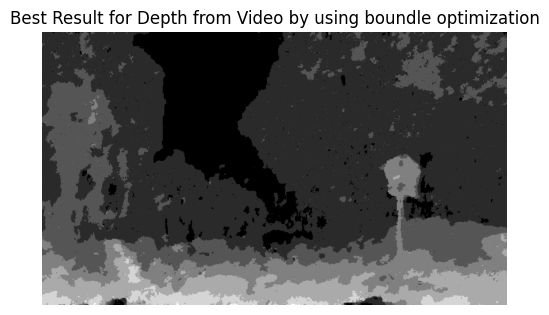

In [62]:
smooth = 1 - 1 * np.eye(d_number)
for q in range(d_number):
    for p in range(d_number):
        if q != p:
            smooth[q][p] = min(abs(q - p), 10)

print('get_depth_map................................')
depthmap = get_depth_map(final_unary, smooth, lambda_factor=0.06)
depthmap = depthmap[:, 0:920]
plt.figure(num=1, dpi=100, figsize=(6, 6))
plt.imshow(depthmap, cmap='gray')
plt.title('Best Result for Depth from Video by using boundle optimization')
plt.axis("off")
plt.show()

In [63]:
def get_smooth_simple(d_number, threshold):
    smooth = np.zeros((d_number, d_number))
    for i in range(d_number):
        for j in range(d_number):
            if i != j:
                smooth[i][j] = min(abs(i - j), threshold)
    return smooth

In [64]:
import numpy as np

disparity = np.arange(0, 0.02, 0.02 / 65)
d_numbers = len(disparity)
print(d_numbers)
a = get_smooth_simple(d_numbers, 10)
print(a)

65
[[ 0.  1.  2. ... 10. 10. 10.]
 [ 1.  0.  1. ... 10. 10. 10.]
 [ 2.  1.  0. ... 10. 10. 10.]
 ...
 [10. 10. 10. ...  0.  1.  2.]
 [10. 10. 10. ...  1.  0.  1.]
 [10. 10. 10. ...  2.  1.  0.]]
